# Newsgroups

In [60]:
import re
import csv
import json
import os

newsgroups = os.listdir("./newsgroups")
for title in newsgroups:
    if ".csv" not in title:
        title_san = title.replace(".txt","")
        # File paths
        input_file = './newsgroups/' + title  # Replace with the path to your file
        csv_output_file = title_san + '.csv'
        json_output_file = title_san + '.json'
        
        # Initialize lists to store posts
        posts = []
        
        # Regular expressions to parse fields
        newsgroup_pattern = re.compile(r'^Newsgroup: (.+)$', re.MULTILINE)
        document_id_pattern = re.compile(r'^document_id: (\d+)$', re.MULTILINE)
        from_pattern = re.compile(r'^From: (.+)$', re.MULTILINE)
        subject_pattern = re.compile(r'^Subject: (.+)$', re.MULTILINE)
        
        # Read the file content
        with open(input_file, 'r') as file:
            content = file.read()
        if content.startswith("From: "):  # Ensure consistency for the first block
            content = "\nNewsgroup:" + content  # Normalize so the first post includes "Newsgroup" and means first post in eg alt.atheism is huge, includes all posts without newsgroup and documentid

        # Split posts using the pattern for new posts
        raw_posts = re.split(r'(?=\nNewsgroup: )', content)
        for raw_post in raw_posts:
            if not raw_post.strip():
                continue
        
            post = {}
            post['newsgroup'] = title_san
            post['document_id'] = document_id_pattern.search(raw_post)
            post['sender'] = from_pattern.search(raw_post)
            post['subject'] = subject_pattern.search(raw_post)
            if title_san == "alt.atheism":
                print(post)
            
            # Extract and clean up fields
            post['document_id'] = post['document_id'].group(1) if post['document_id'] else ''
            post['sender'] = post['sender'].group(1) if post['sender'] else ''
            post['subject'] = post['subject'].group(1) if post['subject'] else ''
        
            # Extract post content (everything after Subject:)
            content_start = post['subject'] and raw_post.find(post['subject']) + len(post['subject'])
            post['content'] = raw_post[content_start:].strip() if content_start else ''
        
            posts.append(post)
        
        # Write to JSON
        with open(json_output_file, 'w', encoding='utf-8') as jsonfile:
            json.dump(posts, jsonfile, ensure_ascii=False, indent=4)

    print(f"Data has been converted and saved to {json_output_file}.")


{'newsgroup': 'alt.atheism', 'document_id': None, 'sender': <re.Match object; span=(11611, 11645), match='From: mathew <mathew@mantis.co.uk>'>, 'subject': <re.Match object; span=(46, 89), match='Subject: Alt.Atheism FAQ: Atheist Resources'>}
{'newsgroup': 'alt.atheism', 'document_id': <re.Match object; span=(24, 42), match='document_id: 49960'>, 'sender': <re.Match object; span=(43, 77), match='From: mathew <mathew@mantis.co.uk>'>, 'subject': <re.Match object; span=(78, 121), match='Subject: Alt.Atheism FAQ: Atheist Resources'>}
{'newsgroup': 'alt.atheism', 'document_id': <re.Match object; span=(24, 42), match='document_id: 51060'>, 'sender': <re.Match object; span=(43, 77), match='From: mathew <mathew@mantis.co.uk>'>, 'subject': <re.Match object; span=(78, 127), match='Subject: Alt.Atheism FAQ: Introduction to Atheism>}
{'newsgroup': 'alt.atheism', 'document_id': <re.Match object; span=(24, 42), match='document_id: 51119'>, 'sender': <re.Match object; span=(43, 95), match='From: I3150

In [57]:
import json
import re

with open('./rec.autos.json', 'r') as file:
    data = json.load(file)

#print(data)
message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
content = data[0]["content"]
print(data[0]["content"])
emails = email_pattern.findall(content)
print("Emails: ", emails)
message_ids =message_id_pattern.findall(content)
message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
print("Message IDs:",message_ids_san)

emails_filtered = [email for email in emails if email not in message_ids_san]

print(emails_filtered)




Emails:  []
Message IDs: []
[]


In [123]:
import json
import re
import os
import networkx as nx

newsgroups = os.listdir("./newsgroups")
newsgroups.remove("list.csv")
graphs = {}
message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
for title in newsgroups:
    G = nx.DiGraph()
    with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
        data = json.load(file)
    for i,post in enumerate(data):
        if "alt.atheism" in title and i == 0:
            #skip first post in alt.atheism (doesn't have standard post metadata)
            print("skipping first", i)
            continue
        sender_email = email_pattern.search(post["sender"].lower())
        if sender_email == None:
            #If no email found, skip
            continue
        sender_email = sender_email.group(0)
        #print(sender_email)
        G.add_node(sender_email)
        #print(post)
        content = post["content"].lower()
        emails = email_pattern.findall(content)
        #print("Emails:\n ", emails)
        message_ids = message_id_pattern.findall(content)
        message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
        #print("Message IDs:\n ",message_ids_san)
        
        emails_filtered = [email for email in emails if email not in message_ids_san]
        for email in emails_filtered:
            if email != sender_email:
                G.add_edge(sender_email,email)
            else:
                email = email
                #print(email,"is equal to",sender_email)
        
        #print("Filtered:\n ",emails_filtered)
    graphs[title.replace(".txt","")] = G


skipping first 0


alt.atheism
191


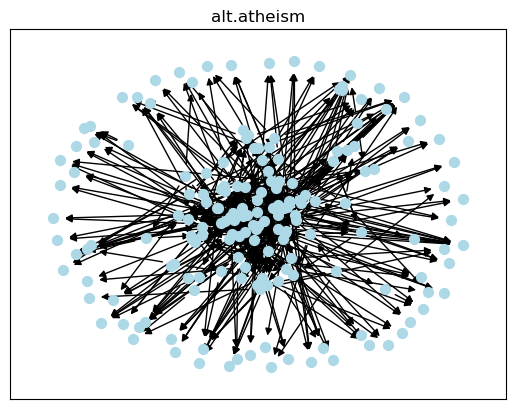

comp.graphics
681


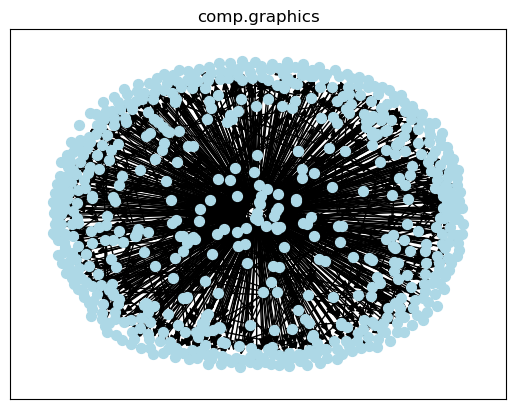

comp.os.ms-windows.misc
340


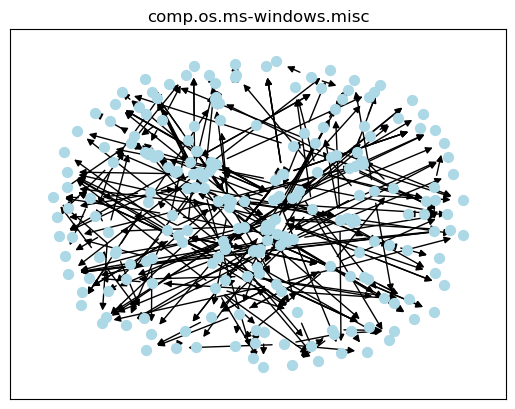

comp.sys.ibm.pc.hardware
278


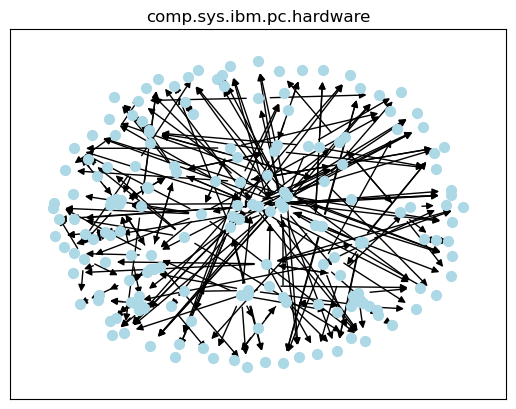

comp.sys.mac.hardware
262


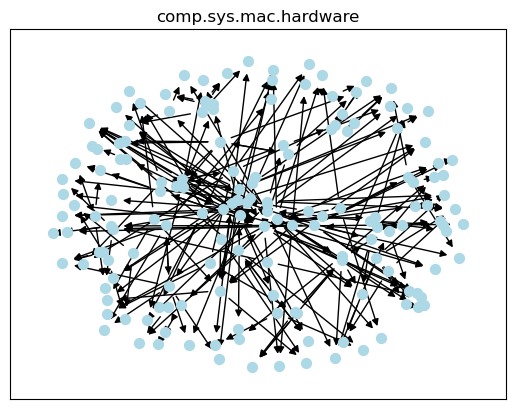

comp.windows.x
277


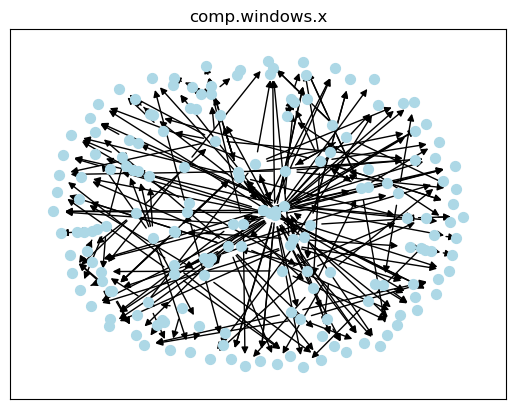

misc.forsale
65


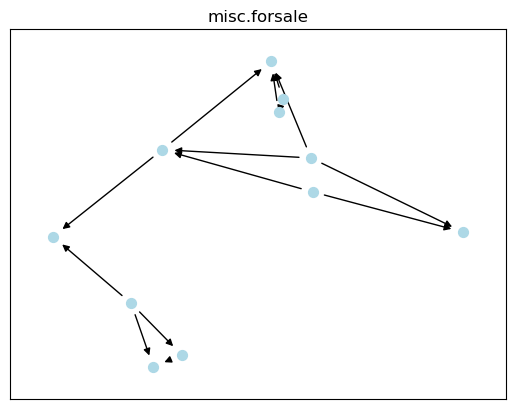

rec.autos
332


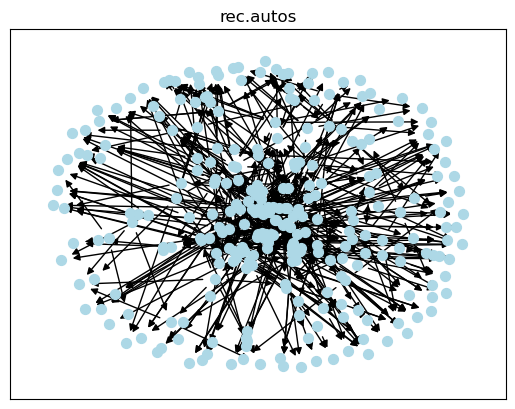

rec.motorcycles
305


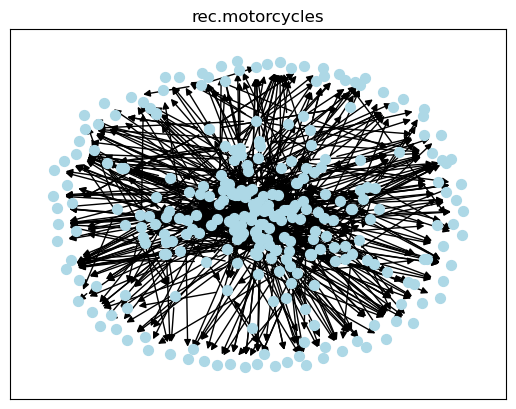

rec.sport.baseball
299


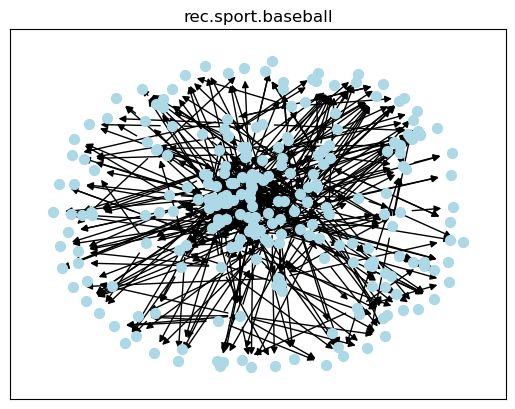

rec.sport.hockey
280


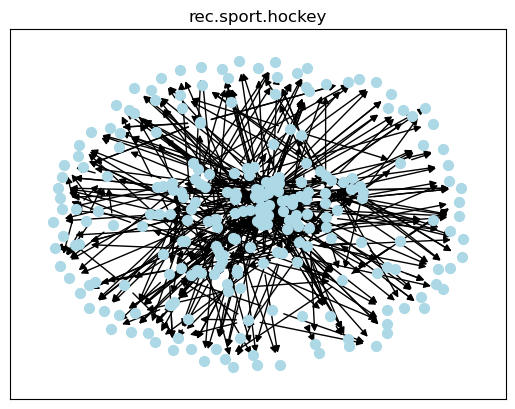

sci.crypt
282


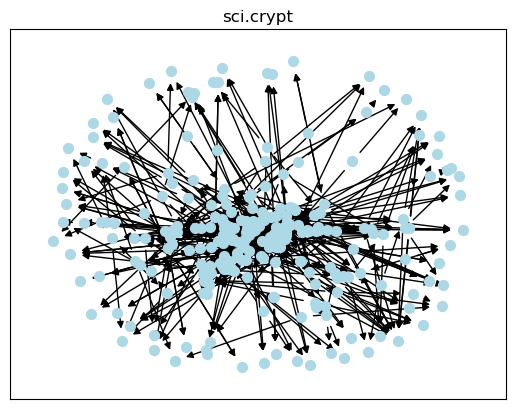

sci.electronics
320


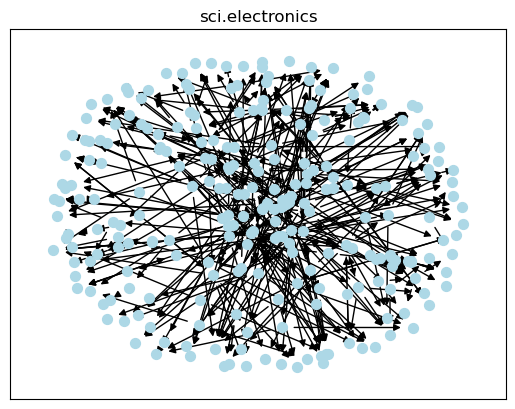

sci.med
298


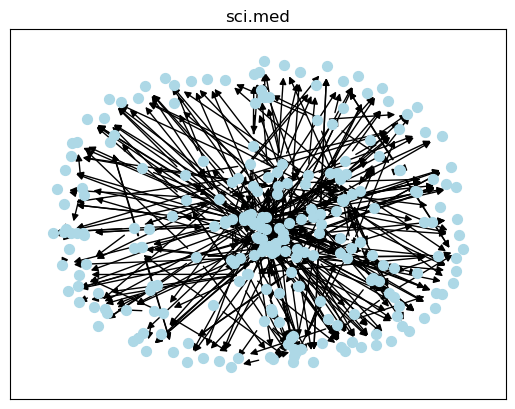

sci.space
300


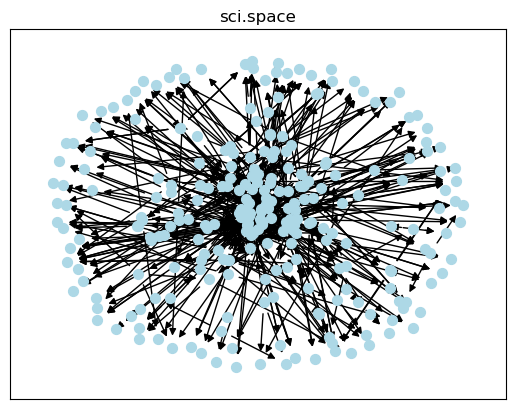

soc.religion.christian
234


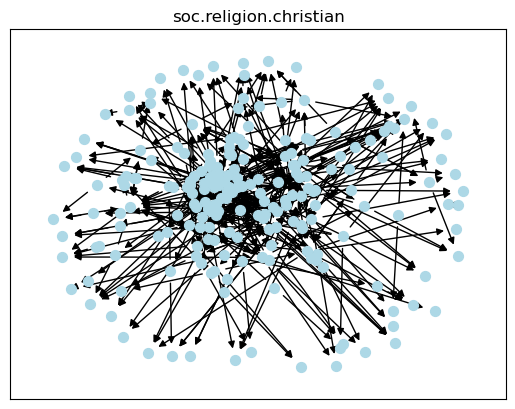

talk.politics.guns
271


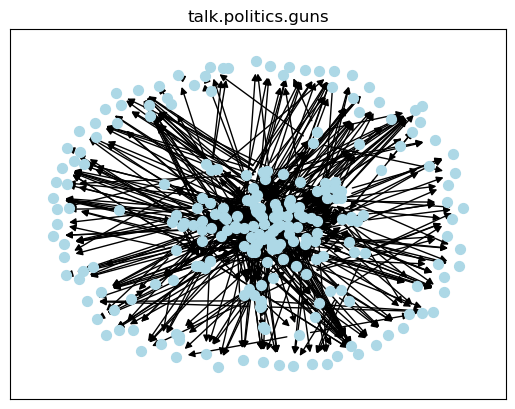

talk.politics.mideast
198


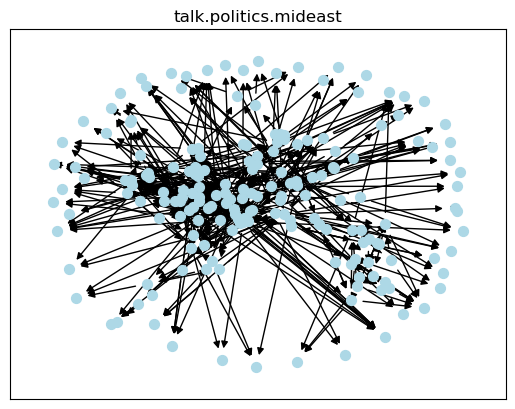

talk.politics.misc
275


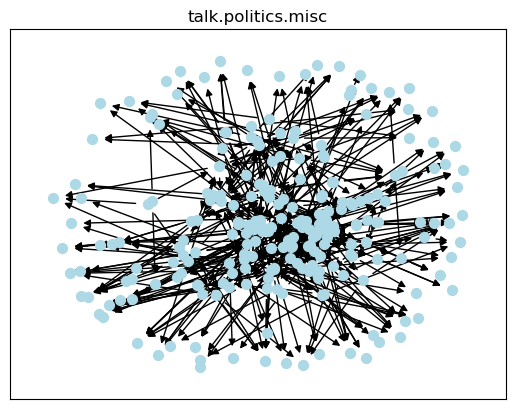

talk.religion.misc
232


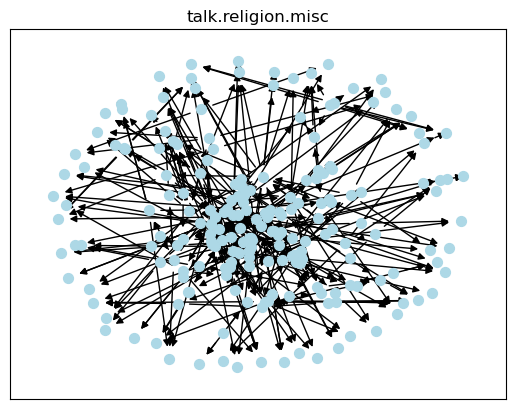

In [126]:
import matplotlib.pyplot as plt
#print(graphs)
for title, graph in graphs.items():
    print(title)
    print(len(graph.nodes()))
    G = graph
    isolated = [node for node in G.nodes if G.degree(node) <= 1]
    #print(isolated)
    G.remove_nodes_from(isolated)
    # Find the largest weakly connected component
    #print(list(nx.weakly_connected_components(G)))
    largest_component = max(nx.weakly_connected_components(G), key=len)
    G_largest = G.subgraph(largest_component).copy()
    
    pos = nx.spring_layout(G_largest)  # Layout algorithm to position nodes
    
    # Draw the nodes and edges
    nx.draw_networkx_nodes(G_largest, pos, node_size=50, node_color="lightblue")
    nx.draw_networkx_edges(G_largest, pos, edgelist=G_largest.edges, arrowstyle='-|>', arrowsize=10)
    
    # Draw the labels with smaller font size
    #nx.draw_networkx_labels(G_largest, pos, font_size=8, font_color="black")
    plt.title(title)
    plt.show()

In [127]:
G = nx.DiGraph()
for title in newsgroups:
    with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
        data = json.load(file)
    for i,post in enumerate(data):
        if "alt.atheism" in title and i == 0:
            #skip first post in alt.atheism (doesn't have standard post metadata)
            print("skipping first", i)
            continue
        sender_email = email_pattern.search(post["sender"].lower())
        if sender_email == None:
            #If no email found, skip
            continue
        sender_email = sender_email.group(0)
        #print(sender_email)
        G.add_node(sender_email)
        #print(post)
        content = post["content"].lower()
        emails = email_pattern.findall(content)
        #print("Emails:\n ", emails)
        message_ids = message_id_pattern.findall(content)
        message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
        #print("Message IDs:\n ",message_ids_san)
        
        emails_filtered = [email for email in emails if email not in message_ids_san]
        for email in emails_filtered:
            if email != sender_email:
                G.add_edge(sender_email,email)
            else:
                email = email
                #print(email,"is equal to",sender_email)
        
        #print("Filtered:\n ",emails_filtered)

skipping first 0


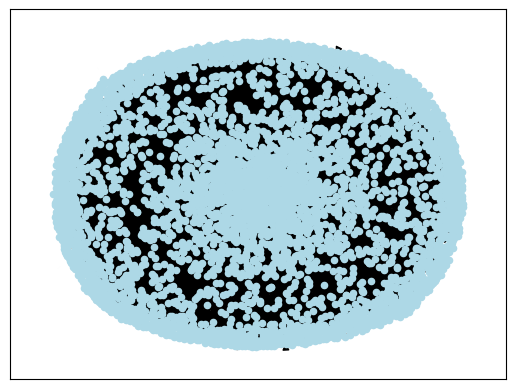

In [130]:
isolated = [node for node in G.nodes if G.degree(node) <= 1]
#print(isolated)
G.remove_nodes_from(isolated)
# Find the largest weakly connected component
#print(list(nx.weakly_connected_components(G)))
largest_component = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

pos = nx.spring_layout(G_largest)  # Layout algorithm to position nodes

# Draw the nodes and edges
nx.draw_networkx_nodes(G_largest, pos, node_size=20, node_color="lightblue")
nx.draw_networkx_edges(G_largest, pos, edgelist=G_largest.edges, arrowstyle='-|>', arrowsize=10)

# Draw the labels with smaller font size
#nx.draw_networkx_labels(G_largest, pos, font_size=8, font_color="black")
#plt.title(title)
plt.show()

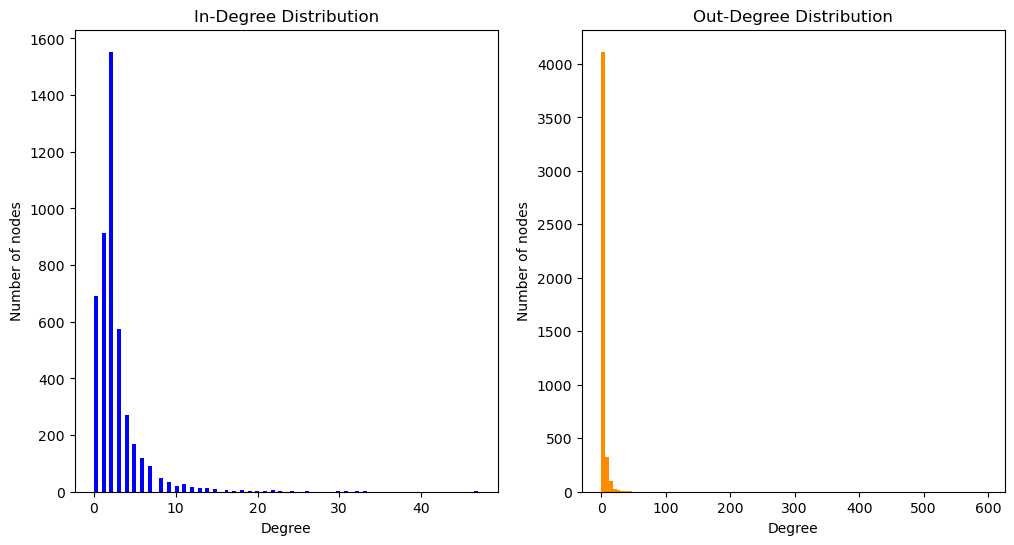

In [132]:
in_degrees = [degree for node,degree in G_largest.in_degree()]
out_degrees = [degree for node,degree in G_largest.out_degree()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=100, color='blue')
plt.title('In-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=100, color='darkorange')
plt.title('Out-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.show()

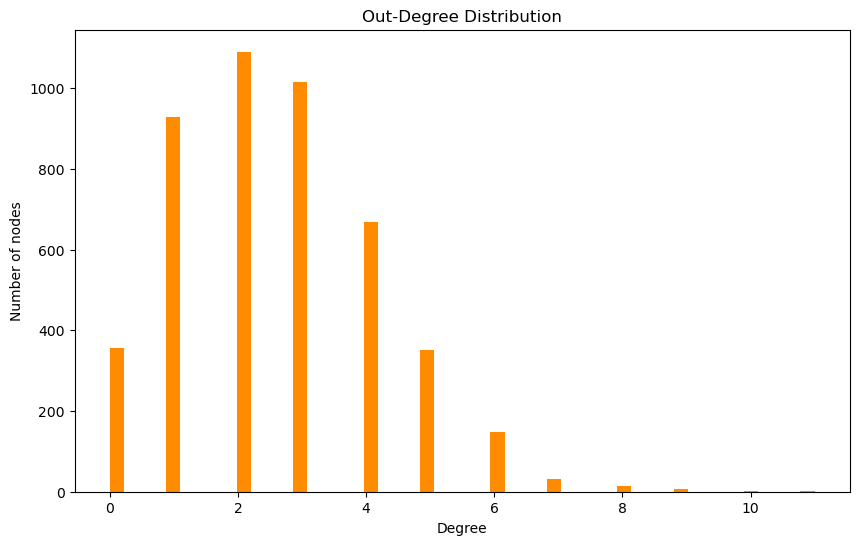

In [134]:
D = nx.gnm_random_graph(len(G_largest.nodes()), len(G_largest.edges()), directed=True)

out_degrees_D = [degree for node, degree in D.out_degree()]

plt.figure(figsize=(10, 6))
plt.hist(out_degrees_D, bins=50, color='darkorange')
plt.title('Out-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.show()

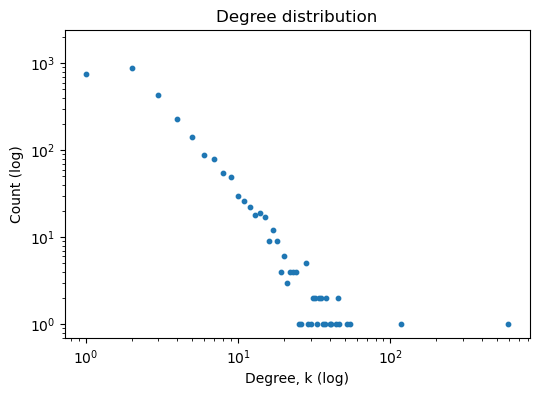

In [136]:
import numpy as np
degree_counts = np.bincount(out_degrees)
degree_range = np.arange(len(degree_counts))

plt.figure(figsize=(6, 4))
plt.scatter(degree_range,degree_counts, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree, k (log)")
plt.ylabel("Count (log)")
plt.title("Degree distribution")
plt.show()

In [138]:
in_degree_dict = dict(G_largest.in_degree())
out_degree_dict = dict(G_largest.out_degree())

#Sort dictionary by second item of tuple
top_5_in_degree = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5] 
top_5_out_degree = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print(top_5_in_degree)

print(top_5_out_degree)


[('strnlght@netcom.com', 47), ('sandvik@newton.apple.com', 33), ('henry@zoo.toronto.edu', 33), ('prb@access.digex.com', 32), ('cdt@sw.stratus.com', 31)]
[('weston@ucssun1.sdsu.edu', 596), ('nfotis@ntua.gr', 118), ('henry@zoo.toronto.edu', 54), ('cdt@sw.stratus.com', 52), ('livesey@solntze.wpd.sgi.com', 46)]


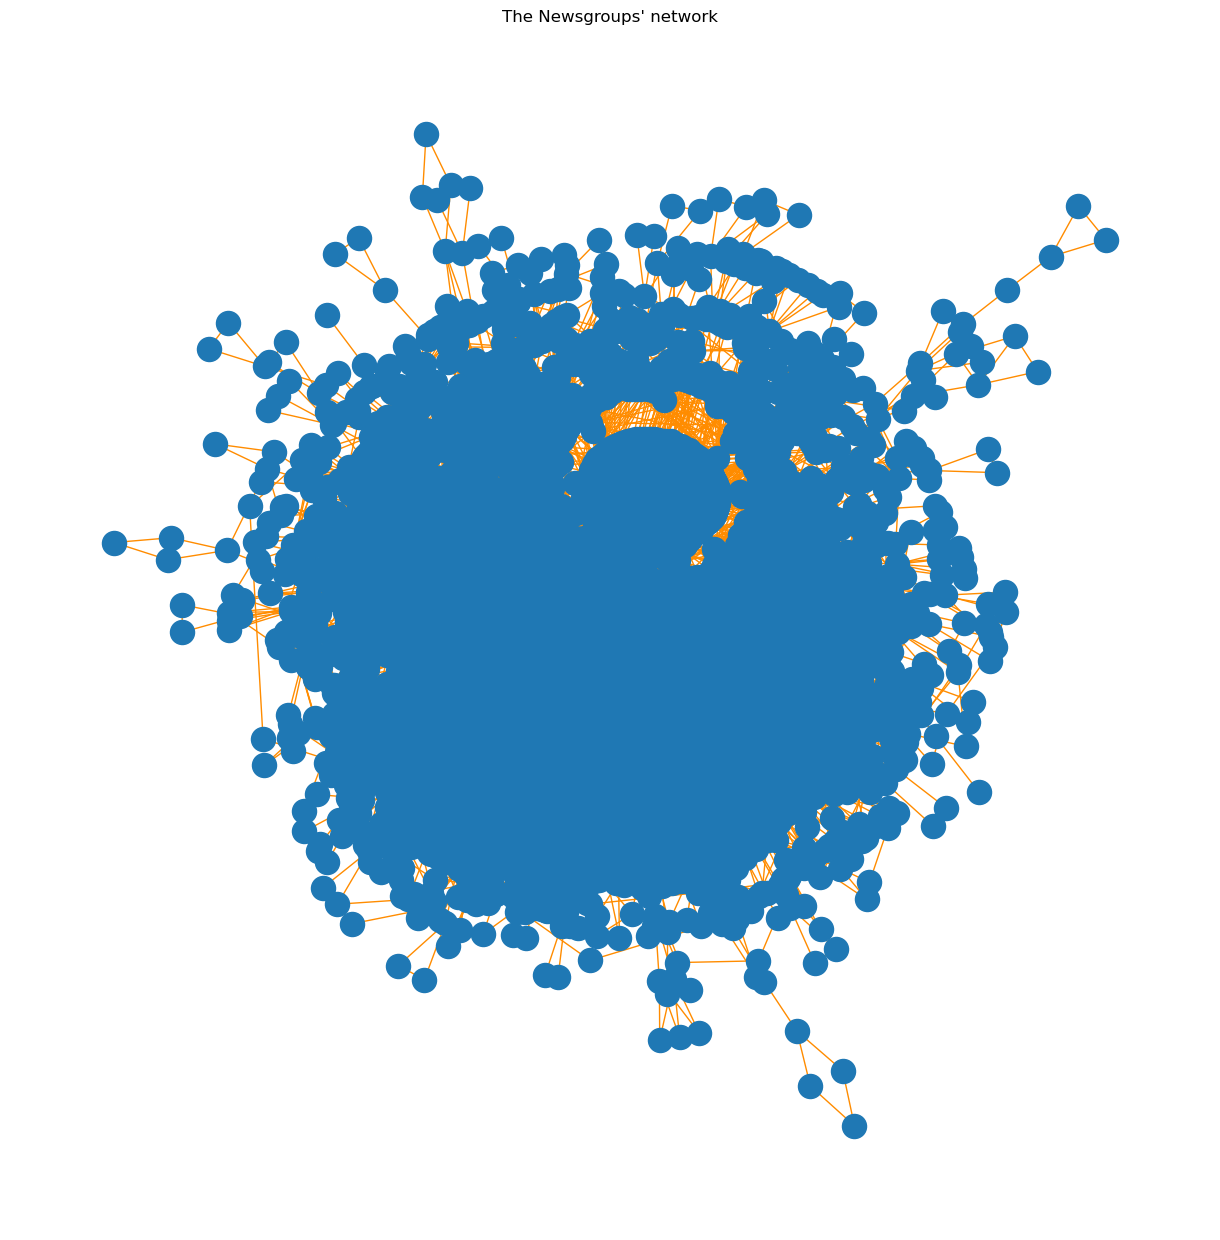

In [141]:
import matplotlib
G_undir = G.to_undirected()

plt.figure(figsize=(12, 12))
nx.draw(G_undir, nx.kamada_kawai_layout(G_undir), with_labels=False, edge_color='darkorange')
plt.title("The Newsgroups' network")
plt.show()